# Validation Example

There are many ways to validate a model with scalecast and this notebook introduces them and overviews the differences between dynamic and non-dynamic tuning/testing, backtesting, and fitted values.

- Download data: https://www.kaggle.com/robervalt/sunspots  
- See here for EDA on this dataset: https://scalecast-examples.readthedocs.io/en/latest/rnn/rnn.html  
- See here for documentation on cross validation: https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.cross_validate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster

In [2]:
sns.set(rc={"figure.figsize": (12, 8)})

In [3]:
def prepare_fcst(f, test_length=0.1, fcst_length=1):
    """ adds all variables and sets the test length/forecast length in the object
    
    Args:
        f (Forecaster): the Forecaster object.
        test_length (int or float): the test length as a size or proportion.
        fcst_length (int): the forecast horizon.
        
    Returns:
        (Forecaster) the processed object.
    """
    f.generate_future_dates(fcst_length)
    f.set_test_length(test_length)
    f.set_validation_length(f.test_length)
    f.add_seasonal_regressors("month", raw=False, dummy=True)
    for i in np.arange(60, 289, 12):  # 12-month cycles from 12 to 288 months
        f.add_cycle(i)
    f.add_ar_terms(120)  # AR 1-120
    f.add_AR_terms((20, 12))  # seasonal AR up to 20 years, spaced one year apart
    f.add_seasonal_regressors("year")
    return f


def export_results(f):
    """ returns a dataframe with all model results given a Forecaster object.
    
    Args:
        f (Forecaster): the Forecaster object.
        
    Returns:
        (DataFrame) the dataframe with the pertinent results.
    """
    results = f.export("model_summaries", determine_best_by="TestSetMAE")
    results["N_Xvars"] = results["Xvars"].apply(lambda x: len(x))
    return results[
        [
            "ModelNickname",
            "TestSetRMSE",
            "InSampleRMSE",
            "ValidationMetric",
            "ValidationMetricValue",
            "HyperParams",
            "TestSetLength",
            "ValidationSetLength",
            "Tuned",
            "CrossValidated",
            "DynamicallyTested",
        ]
    ]

## Load Forecaster Object
- we choose 120 periods (10 years) for all validation and forecasting
- 10 years of observervations to tune model hyperparameters, 10 years to test, and a forecast horizon of 10 years

In [4]:
df = pd.read_csv("Sunspots.csv", index_col=0, names=["Date", "Target"], header=0)
f = Forecaster(y=df["Target"], current_dates=df["Date"])
prepare_fcst(f)

Forecaster(
    DateStartActuals=1749-01-31T00:00:00.000000000
    DateEndActuals=2021-01-31T00:00:00.000000000
    Freq=M
    N_actuals=3265
    ForecastLength=1
    Xvars=['month_1', 'month_10', 'month_11', 'month_12', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'cycle60sin', 'cycle60cos', 'cycle72sin', 'cycle72cos', 'cycle84sin', 'cycle84cos', 'cycle96sin', 'cycle96cos', 'cycle108sin', 'cycle108cos', 'cycle120sin', 'cycle120cos', 'cycle132sin', 'cycle132cos', 'cycle144sin', 'cycle144cos', 'cycle156sin', 'cycle156cos', 'cycle168sin', 'cycle168cos', 'cycle180sin', 'cycle180cos', 'cycle192sin', 'cycle192cos', 'cycle204sin', 'cycle204cos', 'cycle216sin', 'cycle216cos', 'cycle228sin', 'cycle228cos', 'cycle240sin', 'cycle240cos', 'cycle252sin', 'cycle252cos', 'cycle264sin', 'cycle264cos', 'cycle276sin', 'cycle276cos', 'cycle288sin', 'cycle288cos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR1

In [5]:
f.set_estimator("gbt")

In the [feature_selection](https://scalecast-examples.readthedocs.io/en/latest/misc/feature-selection/feature_selection.html) notebook, gbt was chosen as the best model class out of several tried. We will show all examples with this estimator.

## Default Model Parameters
- one with dynamic testing
- one with non-dynamic testing

In [6]:
f.manual_forecast(call_me="gbt_default_non-dynamic", dynamic_testing=False)
f.manual_forecast(call_me="gbt_default_dynamic")  # default is dynamic testing

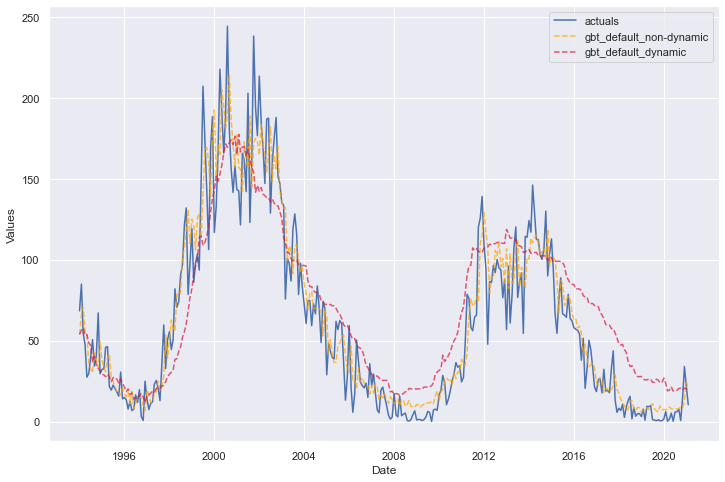

In [7]:
f.plot_test_set(
    models=["gbt_default_non-dynamic", "gbt_default_dynamic"], include_train=False
)
plt.show()

It appears that the non-dynamically tested model performed significantly better than the other, but looks can be deceiving. Setting `dynamic_testing=False` made it so that the model knew all the past values in the data while the model was being tested, including those past values that fall within the test-set window. In essence, this model was only tested for its ability to perform 326 one-step forecasts and its final metric is an average of these one-step forecasts. It could be a good idea to set `dynamic_testing=False` if you want to speed up the testing process or if you only care about how your model would perform one step into the future. But to report the test-set metric from this model as if it could be expected to do that well the full 326 periods into the future is misleading. The other model that was dynamically tested can be more realistically trusted in that regard.

In [8]:
export_results(f)

,ModelNickname,TestSetRMSE,InSampleRMSE,ValidationMetric,ValidationMetricValue,HyperParams,TestSetLength,ValidationSetLength,Tuned,CrossValidated,DynamicallyTested
0,gbt_default_non-dynamic,18.806738,18.841733,None,None,{},326,None,False,False,False
1,gbt_default_dynamic,27.084496,18.841733,None,None,{},326,None,False,False,True


## Tune the model to find optimal hyperparameters
- create a validation grid
- try three strategies to tune the parameters:
  - train/validation/test split
    - hyperparameters are tried on the validation set
  - train/test split with 5-fold time-series cross-validation on training set
    - training data split 5 times into train/validations set
    - models trained on training set only
    - validated out-of-sample
    - all data available before each validation split sequentially used to train the model
  - train/test split with 5-fold time-series rolling cross-validation on training set
    - rolling is different in that each train/validation split is the same size
- use dynamic testing on all these models
- use non-dynamic tuning to speed up performance, but that can be changed by passing `dynamic_tuning=True` to `tune()` and `cross_validate()` methods

In [9]:
grid = {
    "max_depth": [2, 3, 5, None],
    "max_features": ["sqrt", "auto"],
    "subsample": [0.8, 0.9, 1],
}

In [10]:
f.ingest_grid(grid)

### Train/Validation/Test Split
- the data's sequence is maintained in time-series splits

![](./mermaid-diagram-20220614194220.png)

In [11]:
f.tune()
f.auto_forecast(
    call_me="gbt_tuned"
)  # automatically uses optimal paramaeters suggested from the tuning process

In [12]:
f.export_validation_grid("gbt_tuned").sort_values("metric_value").head(10)

,max_depth,max_features,subsample,validation_length,validation_metric,metric_value
5,2.0,auto,1.0,326,rmse,25.836509
4,2.0,auto,0.9,326,rmse,26.071978
3,2.0,auto,0.8,326,rmse,26.176640
11,3.0,auto,1.0,326,rmse,26.517616
9,3.0,auto,0.8,326,rmse,26.633092
16,5.0,auto,0.9,326,rmse,26.682550
10,3.0,auto,0.9,326,rmse,26.854688
15,5.0,auto,0.8,326,rmse,27.287668
17,5.0,auto,1.0,326,rmse,27.922170
8,3.0,sqrt,1.0,326,rmse,27.936418


### 5-Fold Time Series Cross Validation
- split training set into k (5) folds
- each validation set is the same size
- model trained and re-trained with all data that came before each validation slice
- each fold tested out of sample
- final error is an average of the out-of-sample error obtained from each folds
- the chosen hyperparameters are determined by which final error was minimized
- below is an example with a dataset sized 100 observations and in which 10 observations are held out for testing and the remaining 90 observations are used as the training set:

![](./cv.png)

In [13]:
f.cross_validate(k=5)
f.auto_forecast(call_me="gbt_cv")

In [14]:
f.export_validation_grid("gbt_cv").sort_values("metric_value").head(10)

,max_depth,max_features,subsample,validation_length,validation_metric,metric_value,fold,rolling,train_length
47,3.0,auto,1.0,449,rmse,24.147787,2,False,1592
41,2.0,auto,1.0,449,rmse,24.180227,2,False,1592
46,3.0,auto,0.9,449,rmse,24.286763,2,False,1592
40,2.0,auto,0.9,449,rmse,24.412046,2,False,1592
51,5.0,auto,0.8,449,rmse,24.635934,2,False,1592
52,5.0,auto,0.9,449,rmse,24.694690,2,False,1592
29,3.0,auto,1.0,449,rmse,24.724606,1,False,2041
22,2.0,auto,0.9,449,rmse,24.764702,1,False,2041
39,2.0,auto,0.8,449,rmse,24.807071,2,False,1592
53,5.0,auto,1.0,449,rmse,24.921920,2,False,1592


### 5-Fold Rolling Time Series Cross Validation
- split training set into k (5) folds
- each validation set is the same size
- each training set is also the same size as each validation set
- each fold tested out of sample
- final error is an average of the out-of-sample error obtained from each folds
- the chosen hyperparameters are determined by which final error was minimized
- below is an example with a dataset sized 100 observation and in which 10 observations are held out for testing and the remaining 90 observations are used as the training set:

![](./rolling_cv.png)

In [15]:
f.cross_validate(k=5, rolling=True)
f.auto_forecast(call_me="gbt_rolling_cv")

In [16]:
f.export_validation_grid("gbt_rolling_cv").sort_values("metric_value").head(10)

,max_depth,max_features,subsample,validation_length,validation_metric,metric_value,fold,rolling,train_length
39,2.0,auto,0.8,449,rmse,27.416819,2,True,449
81,3.0,auto,0.8,449,rmse,27.635399,4,True,449
51,5.0,auto,0.8,449,rmse,27.910089,2,True,449
83,3.0,auto,1.0,449,rmse,27.991909,4,True,449
76,2.0,auto,0.9,449,rmse,28.001340,4,True,449
77,2.0,auto,1.0,449,rmse,28.277495,4,True,449
88,5.0,auto,0.9,449,rmse,28.397722,4,True,449
82,3.0,auto,0.9,449,rmse,28.502345,4,True,449
75,2.0,auto,0.8,449,rmse,28.658843,4,True,449
46,3.0,auto,0.9,449,rmse,28.738881,2,True,449


### View results

<AxesSubplot:xlabel='Date', ylabel='Values'>

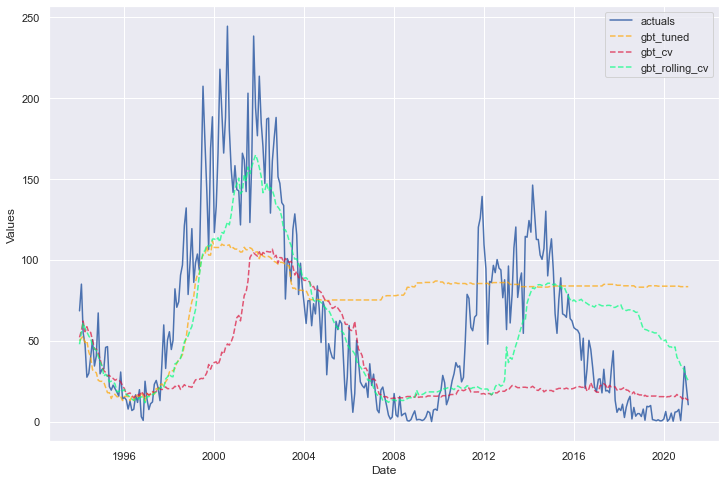

In [17]:
f.plot_test_set(
    models=["gbt_tuned", "gbt_cv", "gbt_rolling_cv"], include_train=False,
)

In [18]:
export_results(f)

,ModelNickname,TestSetRMSE,InSampleRMSE,ValidationMetric,ValidationMetricValue,HyperParams,TestSetLength,ValidationSetLength,Tuned,CrossValidated,DynamicallyTested
0,gbt_default_non-dynamic,18.806738,18.841733,None,None,{},326,None,False,False,False
1,gbt_default_dynamic,27.084496,18.841733,None,None,{},326,None,False,False,True
2,gbt_rolling_cv,36.979290,18.668882,rmse,31.844591,"{'max_depth': 3, 'max_features': 'auto', 'subs...",326,None,True,True,True
3,gbt_cv,53.740834,18.616592,rmse,26.569424,"{'max_depth': 3, 'max_features': 'auto', 'subs...",326,None,True,True,True
4,gbt_tuned,52.123829,21.628234,rmse,25.836509,"{'max_depth': 2, 'max_features': 'auto', 'subs...",326,326,True,False,True


## Backtest best model
- backtesting is a process in which the final chosen model is re-validated by seeing its average performance on the last x-number of forecast horizons available in the data
- all forecasating is dynamic to give a true sense of the model's performance on a forecast horizon of that size
- all error metrics are for level data, even if the data in the object was differenced
- in this example, we test the best-performing model (that was dynamically tested) on the last-15 120-period forecasts
- see the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.backtest) for more information

In [20]:
best_model = "gbt_default_dynamic"
f.backtest(best_model, n_iter=15, fcst_length=120)
f.export_backtest_metrics(best_model)

,iter1,iter2,iter3,iter4,iter5,iter6,iter7,iter8,iter9,iter10,iter11,iter12,iter13,iter14,iter15,mean
RMSE,29.852296,30.191771,25.574778,25.490768,43.979648,44.520248,45.970806,51.345371,38.205818,38.879181,23.78589,26.675949,54.103791,50.47784,45.578281,38.308829
MAE,24.724978,25.08619,21.069281,20.872335,39.279382,38.574004,40.053527,45.366901,32.248763,32.796009,19.528299,21.767337,47.786658,44.076658,39.280961,32.834086
R2,0.497793,0.483569,0.629164,0.631571,-0.102393,-0.142933,-0.227577,-0.542061,0.141748,0.105676,0.664482,0.574137,-0.771487,-0.550534,-0.272757,0.074560
MAPE,4.306699,4.569725,4.173612,4.125329,9.516819,13.74453,13.990208,16.598787,7.770295,8.828647,3.299671,3.543573,7.770723,6.296609,4.883942,7.561278


On average, we can expect this model to have an RMSE of 38, MAE of 32 and R2 of 8% over a full 120-period forecast window.

In this example, the best-performing model happened to be the dynamically tested model with default hyperparameters, but optimizing a model with the `tune()` or `cross_validate()` methods often make a significant difference. In this example, changing `dynamic_tuning` to `True` might help the hyperparameter selection because the dataset itself is complex enough that using a non-dynamic tuning method could lead to hyperparameters that are ill-suited for a longer forecast horizon. Changing the estimator grid or estimator type, such as to xgboost, could also make a difference.